### CAP 6640 
### Project 2 - Fake News Detection
### Mar 28, 2024

### Group 4
### Andres Graterol
###                   UCF ID: 4031393
### Zachary Lyons
###                   UCF ID: 4226832
### Christopher Hinkle
###                   UCF ID: 4038573
### Nicolas Leocadio
###                   UCF ID: 3791733

#### Imports

In [18]:
import re 
import nltk
import gensim
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Download necessary resources from nltk
try:
    nltk.data.find('stopwords')
except LookupError:
    nltk.download('stopwords')
    
try:
    nltk.data.find('punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('wordnet')
except LookupError:
    nltk.download('wordnet') 

[nltk_data] Downloading package stopwords to /home/nick_/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nick_/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nick_/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Step 1 - Data Collection

In [19]:
# Read in the training dataset as a dataframe
df = pd.read_csv('train.csv')

# Drop NaN rows from the dataframe to avoid errors
df = df.dropna(how='all', axis=0)

# Merge the author and title into a single column
df['article'] = df['author'] + ' ' + df['title']
# print(df['article'])

# print(df)

#### Step 2 - Data Preprocessing

In [20]:
df['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [21]:
# NOTE: Combine title and author into a single column, diverting from tutorial
# df = df.drop('title', axis=1)
# df = df.drop('author', axis=1)
df.head()

,id,title,author,text,label,article
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Iranian woman jailed for fictio...


In [22]:
# Split data in into data (X) and labels (Y)

# Seclude the labels
# 1 - unreliable
# 0 - reliable
labels = df['label']
#print(labels)

# Get the data excluding the labels
data = df.drop('label', axis=1)
# print(data)

In [23]:
# TODO: This only lemmatises the article feature, not the text found in the article - figure out if we have to do this

# Init lemmatizer 
lemmatizer = WordNetLemmatizer()

cleaned_corpus = []


if os.path.isfile('cleaned_corpus.txt'):
    with open('cleaned_corpus.txt', 'r') as f:
        cleaned_corpus = [line.rstrip() for line in f]
else:
    with open('cleaned_corpus.txt', 'w') as f:
        # For each article (author + title) in the dataframe, clean the text
        for i in range(len(df)):
            # Remove any non-alphanumeric characters
            cleaned_article = re.sub('[^a-zA-Z0-9]', ' ', str(df['article'][i]))
            # Lowercase the text
            cleaned_article = cleaned_article.lower()
            # Split the text into individual words
            cleaned_article = cleaned_article.split()
            # Lemmatize the words and remove any stopwords
            cleaned_article = [lemmatizer.lemmatize(word) for word in cleaned_article if not word in set(stopwords.words('english'))]
            # Join the words back together
            cleaned_article = ' '.join(cleaned_article)
            cleaned_corpus.append(cleaned_article)
            f.write("%s\n" % cleaned_article)

In [24]:
# Drop any lables associated with empty articles
labels = df[list(map(lambda x: len(x) > 0, cleaned_corpus))]
labels = labels['label']

In [25]:
# Remove these empty articles from the corpus 
cleaned_corpus = [i for i in cleaned_corpus if i]
len(cleaned_corpus)

20771

#### Step 3 - Feature Engineering

In [26]:
# Size of the vocabulary - one hot encoding will assign the words with a number in range of 0 to vocab_size
vocab_size = 5000

# One hot encoding the cleaned corpus
onehot_repr=[one_hot(words, vocab_size) for words in cleaned_corpus]

# Finding the Max_len & Min_len of the sentences in the cleaned corpus
def get_min_max_lengths(cleaned_corpus):
    # Arbitrary values to compare against
    min_len = float('inf')
    max_len = float('-inf')

    # Iterate through the corpus to get the max and min length sentences
    for i in cleaned_corpus:
        if len(i.split()) > max_len:
            max_len = len(i.split())
        if len(i.split()) < min_len:
            min_len = len(i.split())
    return min_len, max_len 

min_len, max_len = get_min_max_lengths(cleaned_corpus)
print(min_len, max_len)

1 51


In [27]:
# Pad sentences with zeroes at the start to make them all the same length
embedded_docs = pad_sequences(onehot_repr, padding='pre', maxlen=max_len)

#### Step 4 - Algorithm and Results

In [28]:
# Create the model with 50 features
embedding_vector_features = 50 ## feature representation
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_features))
model.add(LSTM(100)) # 100 Neurons - Hyper-Parameter for LSTM
model.add(Dense(1, activation='sigmoid')) # Output Layer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
X = np.array(embedded_docs)
Y = np.array(labels)

# Train & Test Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)

In [ ]:
# List available devices for tensorflow to see if we are using GPU
print("Num GPUs Available: ", tf.config.list_physical_devices())

In [30]:
# Train da model

if os.path.isfile('model_combined_author_title_gpu.keras'):
    model = tf.keras.models.load_model('model_combined_author_title_gpu.keras')
else:
    model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=20)
# Training on CPU took 11m 37.4s - Nick
# Training on GPU on WSL2 took 11m 34.3s - Nick

Epoch 1/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8797 - loss: 0.2541 - val_accuracy: 0.9867 - val_loss: 0.0486
Epoch 2/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9951 - loss: 0.0200 - val_accuracy: 0.9886 - val_loss: 0.0391
Epoch 3/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9975 - loss: 0.0134 - val_accuracy: 0.9828 - val_loss: 0.0531
Epoch 4/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9983 - loss: 0.0088 - val_accuracy: 0.9881 - val_loss: 0.0483
Epoch 5/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9985 - loss: 0.0083 - val_accuracy: 0.9852 - val_loss: 0.0555
Epoch 6/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9985 - loss: 0.0087 - val_accuracy: 0.9868 - val_loss: 0.0582
Epoch 7/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9989 - loss: 0.0072 - val_accuracy: 0.9862 - val_loss: 0.0567
Epoch 8/100
727/727 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9989 - loss: 0.0075 - val_acc

In [31]:
# Save da model

if os.path.isfile('model_combined_author_title_gpu.keras'):
    pass
else:
    model.save('model_combined_author_title_gpu.keras')

#### Step 5 - Evaluation 

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[1 1 0 ... 0 1 0]
[[9.9999690e-01]
 [1.0000000e+00]
 [2.8567980e-08]
 ...
 [5.0749141e-11]
 [1.0000000e+00]
 [1.7237808e-10]]


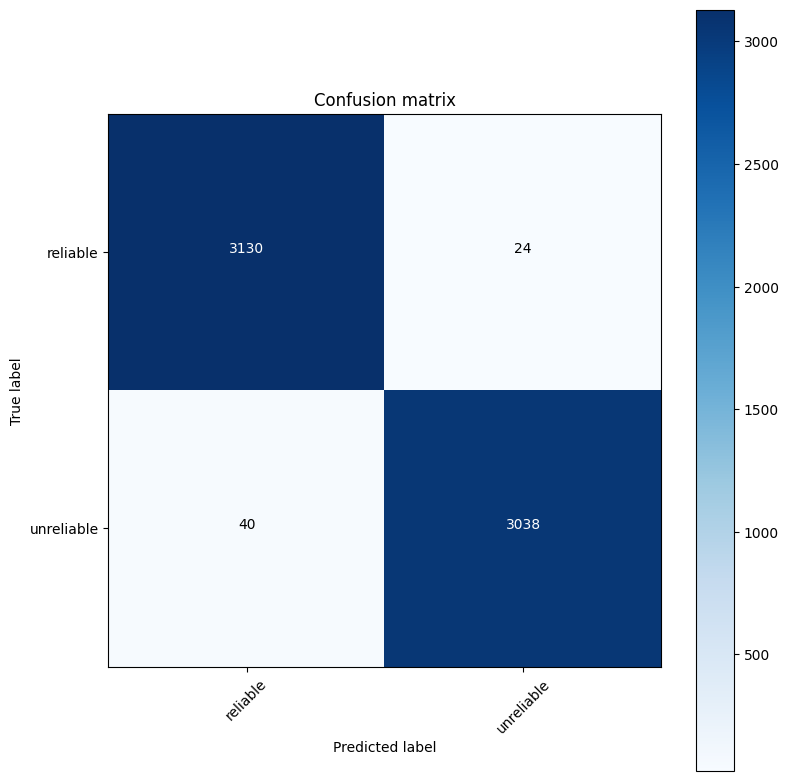

In [32]:
# TODO: THIS y_pred needs to come from the actual testing set (test.csv), NOT the train.csv
y_pred = model.predict(X_test)

print(y_test)
print(y_pred)

cm = confusion_matrix(y_test, y_pred.round())

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 8))

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment='center', color='white' if cm[i, j] > threshold else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, ['reliable', 'unreliable'])


In [33]:
# Accuracy
# NOTE: This accuracy is garbage. Training is overfitting in a huge way plus we are not using the proper test set
accuracy = accuracy_score(y_test, y_pred.round())
print(accuracy)

# Classification Report
classification_report = classification_report(y_test, y_pred.round())
print(classification_report)

0.9897304236200257
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3154
           1       0.99      0.99      0.99      3078

    accuracy                           0.99      6232
   macro avg       0.99      0.99      0.99      6232
weighted avg       0.99      0.99      0.99      6232

